In [1]:
import b3d
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from b3d import Pose, Mesh
import rerun as rr
import genjax

In [2]:
b3d.rr_init()

In [3]:
import importlib
importlib.reload(b3d.mesh)
importlib.reload(b3d.io.data_loader)
importlib.reload(b3d.utils)
importlib.reload(b3d.renderer.renderer_original)

<module 'b3d.renderer.renderer_original' from '/home/nishadgothoskar/b3d/b3d/renderer/renderer_original.py'>

100%|██████████| 39/39 [00:14<00:00,  2.75it/s]


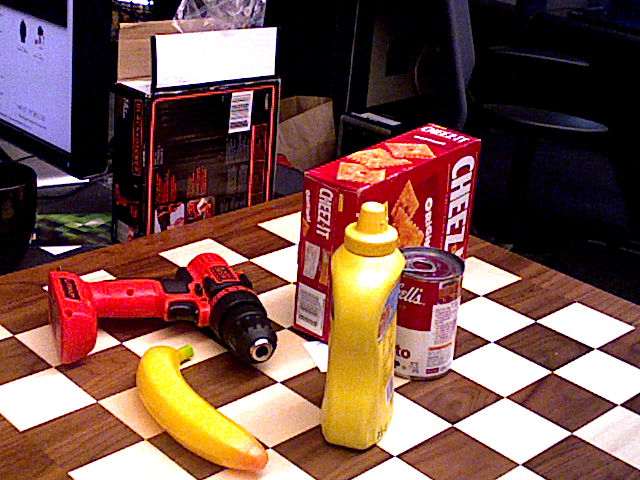

In [4]:
import os
type = "ycbv"
if type == "ycbv":
    scene_id = 50
    ycb_dir = os.path.join(b3d.get_assets_path(), "bop/ycbv")
    num_scenes = b3d.io.data_loader.get_ycbv_num_test_images(ycb_dir, scene_id)
    all_data = b3d.io.get_ycbv_test_images(ycb_dir, scene_id, range(1,num_scenes,50))
elif type == "ycbineaot":
    videoname = "mustard0"
    ycb_dir = os.path.join(b3d.get_assets_path(), "bop/ycbv")
    video_dir = os.path.join(b3d.get_assets_path(), f"ycbineoat")
    all_data = b3d.io.data_loader.get_ycbineoat_images(
        video_dir, videoname, range(1, 600, 6)
    )
b3d.viz_rgb(all_data[0]["rgbd"][...,:3])

In [5]:
meshes = [
    Mesh.from_obj_file(os.path.join(ycb_dir, f'models/obj_{f"{id + 1}".rjust(6, "0")}.ply')).scale(0.001)
    for id in all_data[0]["object_types"]
]

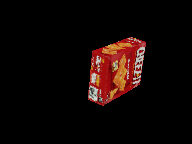

In [6]:
height, width = all_data[0]["rgbd"].shape[:2]
fx,fy,cx,cy = all_data[0]["camera_intrinsics"]
scaling_factor = 0.3
renderer = b3d.renderer.renderer_original.RendererOriginal(
    width * scaling_factor, height * scaling_factor, fx * scaling_factor, fy * scaling_factor, cx * scaling_factor, cy * scaling_factor, 0.01, 2.0
)
IDX = 0
camera_pose = all_data[0]["camera_pose"]
object_poses = all_data[0]["object_poses"]
meshes[IDX].rr_visualize("mesh")
mesh_at_pose = meshes[IDX]
mesh_at_pose = mesh_at_pose.transform(camera_pose.inv() @ object_poses[IDX])
rgbd = renderer.render_rgbd(
    mesh_at_pose.vertices,
    mesh_at_pose.faces,
    mesh_at_pose.vertex_attributes,
)
b3d.viz_rgb(rgbd[...,:3])

In [7]:
def gaussian_ray_intermediate(observed_rgbd, scene_mesh, renderer, likelihood_args):
    rendered_rgbd = renderer.render_rgbd(
        scene_mesh.vertices,
        scene_mesh.faces,
        scene_mesh.vertex_attributes,
    )

    fx = renderer.fx
    fy = renderer.fy

    rendered_rgb = rendered_rgbd[..., :3]
    observed_rgb = observed_rgbd[..., :3]

    rendered_depth = rendered_rgbd[...,3]
    observed_depth = observed_rgbd[...,3]

    observed_depth_corrected = observed_depth + (observed_depth == 0.0) * renderer.far

    rendered_areas = (rendered_depth / fx) * (rendered_depth / fy)
    observed_areas = (observed_depth_corrected / fx) * (observed_depth_corrected / fy)

    inlier_score = likelihood_args["inlier_score"]
    outlier_prob = likelihood_args["outlier_prob"]

    observed_lab = b3d.colors.rgb_to_lab(observed_rgb)
    rendered_lab = b3d.colors.rgb_to_lab(rendered_rgb)

    observed_labd = jnp.concatenate([observed_lab, observed_depth[..., None]], axis=-1)
    rendered_labd = jnp.concatenate([rendered_lab, rendered_depth[..., None]], axis=-1)

    bounds = likelihood_args["bounds"]
    variances = likelihood_args["variances"]
    inlier_probability_per_pixel = jax.scipy.stats.truncnorm.pdf(
        observed_labd - rendered_labd, -bounds, bounds,
        loc=jnp.zeros(4),
        scale=variances
    ).prod(-1) * rendered_areas

    teleport_factor = 0.01

    _outlier_probability = observed_areas * outlier_prob

    teleported_mask  = (observed_depth_corrected > rendered_depth) *  (rendered_depth > 0.0)
    teleport_outlier_probability = _outlier_probability * teleport_factor * teleported_mask
    non_teleport_outlier_probability = _outlier_probability * (1.0 - teleported_mask)

    score = jnp.log(jnp.sum(inlier_probability_per_pixel + teleport_outlier_probability + non_teleport_outlier_probability))

    return {
        "inliers": inlier_probability_per_pixel,
        "outliers": non_teleport_outlier_probability,
        "undecided": teleport_outlier_probability,
        "rendered_rgbd": rendered_rgbd,
        "rendered_lab": rendered_lab,
        "observed_lab": observed_lab,
        "score": score,
    }



def simple_likelihood(observed_rgbd, scene_mesh, renderer, likelihood_args):
    rendered_rgbd = renderer.render_rgbd(
        scene_mesh.vertices,
        scene_mesh.faces,
        scene_mesh.vertex_attributes,
    )

    fx = renderer.fx
    fy = renderer.fy
    far = renderer.far

    rendered_rgb = rendered_rgbd[..., :3]
    observed_rgb = observed_rgbd[..., :3]

    rendered_depth = rendered_rgbd[...,3]
    observed_depth = observed_rgbd[...,3]

    observed_lab = b3d.colors.rgb_to_lab(observed_rgb)
    rendered_lab = b3d.colors.rgb_to_lab(rendered_rgb)

    rendered_areas = (rendered_depth / fx) * (rendered_depth / fy)

    is_hypothesized = (rendered_depth > 0.0)
    
    is_observed_data_rgb = (observed_rgb.min(-1) < 0.99) * (observed_rgb.max(-1) > 0.01)
    is_observed_data_depth = (observed_depth > 0.0)

    bounds = likelihood_args["bounds"]

    color_match = (jnp.abs(observed_lab - rendered_lab) < bounds[:3]).all(-1) * is_hypothesized * is_observed_data_rgb
    depth_match = (jnp.abs(observed_depth - rendered_depth) < bounds[3]) * is_hypothesized * is_observed_data_depth

    is_match = color_match * depth_match
    is_color_matched_but_no_depth_data = color_match * ~is_observed_data_depth
    is_mismatched = (
        is_hypothesized * ~is_match * ~is_color_matched_but_no_depth_data * is_observed_data_rgb * is_observed_data_depth
    )


    score = jnp.sum(
        is_match * rendered_areas * 2.0 + is_mismatched * rendered_areas * -1.0
    ) * likelihood_args["multiplier"]

    return {
        "score": score,
        "is_match": is_match,
        "is_mismatched": is_mismatched,
        "color_match": color_match,
        "depth_match": depth_match,
        "is_hypothesized": is_hypothesized, 
        "rendered_rgbd": rendered_rgbd,     
    }


In [8]:
import genjax
from b3d.modeling_utils import uniform_discrete, uniform_pose, gaussian_vmf
from collections import namedtuple
from genjax import Pytree
import b3d
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax
from b3d import Pose, Mesh
import rerun as rr

import b3d.chisight.dense.likelihoods.image_likelihood
import b3d.chisight.dense.likelihoods.kray_outlier_volume
importlib.reload(b3d.chisight.dense.likelihoods.image_likelihood)
importlib.reload(b3d.chisight.dense.likelihoods.kray_outlier_volume)


# intermediate_likelihood_func = b3d.chisight.dense.likelihoods.kray_outlier_volume.kray_likelihood_intermediate
intermediate_likelihood_func = gaussian_ray_intermediate
intermediate_likelihood_func = simple_likelihood
image_likelihood = b3d.chisight.dense.likelihoods.image_likelihood.make_image_likelihood(
    intermediate_likelihood_func,
    renderer
)

@genjax.gen
def dense_multiobject_model(num_objects, meshes, likelihood_args):
    all_poses = []
    for i in range(num_objects.const):
        object_pose = uniform_pose(jnp.ones(3)*-100.0, jnp.ones(3)*100.0) @ f"object_pose_{i}"
        all_poses.append(object_pose)

    all_poses = Pose.stack_poses([all_poses])
    scene_mesh = Mesh.transform_and_merge_meshes(meshes, all_poses)
    image = image_likelihood(scene_mesh, likelihood_args) @ "image"
    return {"scene_mesh": scene_mesh, "image": image}

def rerun_visualize_trace_t(trace, t):
    rr.set_time_sequence("time", t)
    observed_rgbd = trace.get_retval()["image"]

    intermediate_info = intermediate_likelihood_func(
        observed_rgbd, 
        trace.get_retval()["scene_mesh"],
        renderer,
        trace.get_args()[2]
    )
    rendered_rgbd = intermediate_info["rendered_rgbd"]

    rr.log("rgb", rr.Image(observed_rgbd[...,:3]))
    rr.log("rgb/rendering", rr.Image(rendered_rgbd[...,:3]))
    rr.log("rgb/depth", rr.DepthImage(observed_rgbd[...,3]))
    rr.log("rgb/depth_rendering", rr.DepthImage(rendered_rgbd[...,3]))
    info_string = f"# Score : {trace.get_score()}"
    
    for add in ["is_match", "is_mismatched", "color_match", "depth_match", "is_hypothesized"]:
        rr.log(f"/rgb/overlay/{add}", rr.DepthImage(intermediate_info[add] * 1.0))
    rr.log("/info", rr.TextDocument(info_string))

importance_jit = jax.jit(dense_multiobject_model.importance)

In [13]:
IDX = 3
pose = camera_pose.inv() @ all_data[0]["object_poses"][IDX]
choicemap = genjax.ChoiceMap.d(
    dict(
        [
            ("pose_prior",  pose),
            ("object_pose_0",  pose),
            ("image", 
                b3d.utils.resize_image(
                    all_data[0]["rgbd"], renderer.height, renderer.width
                )
            )
        ]
    )
)

In [14]:
likelihood_args= {
    "inlier_score": 20.0,
    "color_tolerance": 20.0,
    "depth_tolerance": 0.01,
    "outlier_prob": 0.000001,
    "multiplier": 10000.0,
    "bounds": jnp.array([70.0, 45.0, 45.0, 0.005]),
    "variances" : jnp.zeros(4)
}

trace, _ = importance_jit(
    jax.random.PRNGKey(2),
    choicemap,
    (Pytree.const(1), [meshes[IDX]], likelihood_args),
)
trace0 = trace
rerun_visualize_trace_t(trace, 0)
print(trace.get_score())
key = jax.random.PRNGKey(100)

-41.336475


In [15]:
from b3d.bayes3d.enumerative_proposals import gvmf_and_select_best_move
from tqdm import tqdm
trace = trace0
tracking_results = {}
for t in tqdm(range(len(all_data))):
# for t in tqdm(range(10)):
    trace = b3d.update_choices_jit(trace, jax.random.PRNGKey(0), ("image","pose_prior"),
        b3d.utils.resize_image(all_data[t]["rgbd"], renderer.height, renderer.width),
        trace.get_choices()["object_pose_0"]
    )
    saved_trace = trace
    potential_traces = []
    for var in [0.02, 0.01, 0.005]:
        trace = saved_trace
        trace, key = gvmf_and_select_best_move(trace, key, var, 700.0, Pytree.const("object_pose_0"), 700)
        trace, key = gvmf_and_select_best_move(trace, key, var, 700.0, Pytree.const("object_pose_0"), 700)
        trace, key = gvmf_and_select_best_move(trace, key, var, 700.0, Pytree.const("object_pose_0"), 700)
        trace, key = gvmf_and_select_best_move(trace, key, var, 700.0, Pytree.const("object_pose_0"), 700)
        potential_traces.append(trace)
    scores = jnp.array([t.get_score() for t in potential_traces])
    trace = potential_traces[scores.argmax()]
    tracking_results[t] = trace
    # print(t, trace.get_score())
    rerun_visualize_trace_t(trace, t)

100%|██████████| 39/39 [00:34<00:00,  1.15it/s]


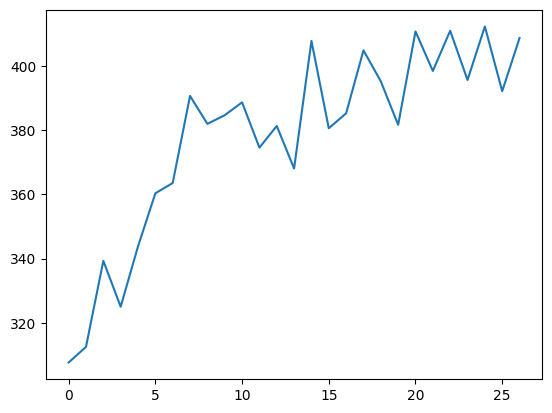

In [245]:
plt.plot([tracking_results[t].get_score() for t in range(len(all_data))])

In [70]:
t = 0
trace_tracking = tracking_results[t]
print(trace_tracking.get_score())

318.74442


In [191]:
from b3d.bayes3d.enumerative_proposals import gvmf_and_select_best_move
from tqdm import tqdm
initialized_at_right_pose = {}
for t in tqdm(range(len(all_data))):
# for t in [0,1,2]:
    trace = b3d.update_choices_jit(trace, jax.random.PRNGKey(0), ("image",),
        b3d.utils.resize_image(all_data[t]["rgbd"], renderer.height, renderer.width)
    )
    trace = b3d.update_choices_jit(trace, jax.random.PRNGKey(0), ("object_pose_0",),
        all_data[t]["camera_pose"].inv() @ all_data[t]["object_poses"][IDX]
    )

    trace, key = gvmf_and_select_best_move(trace, key, 0.01, 800.0, Pytree.const("object_pose_0"), 700)
    trace, key = gvmf_and_select_best_move(trace, key, 0.02, 800.0, Pytree.const("object_pose_0"), 700)
    trace, key = gvmf_and_select_best_move(trace, key, 0.001, 1000.0, Pytree.const("object_pose_0"), 700)
    trace, key = gvmf_and_select_best_move(trace, key, 0.01, 800.0, Pytree.const("object_pose_0"), 700)
    trace, key = gvmf_and_select_best_move(trace, key, 0.02, 800.0, Pytree.const("object_pose_0"), 700)
    trace, key = gvmf_and_select_best_move(trace, key, 0.001, 1000.0, Pytree.const("object_pose_0"), 700)
    initialized_at_right_pose[t] = trace
    # print(t, trace.get_score())
    # rerun_visualize_trace_t(trace, t)

100%|██████████| 16/16 [00:04<00:00,  3.33it/s]


In [195]:
t = 3
trace_tracking = tracking_results[t]
print(trace_tracking.get_score())
trace_initialization = initialized_at_right_pose[t]
rerun_visualize_trace_t(trace_initialization, t)
print(trace_initialization.get_score())


info_tracking = intermediate_likelihood_func(
    trace_tracking.get_retval()["image"], 
    trace_tracking.get_retval()["scene_mesh"],
    renderer,
    trace_tracking.get_args()[2]
)
info_initialization = intermediate_likelihood_func(
    trace_initialization.get_retval()["image"], 
    trace_initialization.get_retval()["scene_mesh"],
    renderer,
    trace_initialization.get_args()[2]
)

-6.0253487
201.7227


In [ ]:
print("is_match", info_tracking["is_match"].sum(), info_initialization["is_match"].sum())
print("is_mismatched", info_tracking["is_mismatched"].sum(), info_initialization["is_mismatched"].sum())
print("color_match", info_tracking["color_match"].sum(), info_initialization["color_match"].sum())
print("depth_match", info_tracking["depth_match"].sum(), info_initialization["depth_match"].sum())
print("is_hypothesized", info_tracking["is_hypothesized"].sum(), info_initialization["is_hypothesized"].sum())

In [ ]:
66 -  0.7 * 243

In [ ]:
153 -0.7* 423

In [ ]:
t = 13
print(initialized_at_right_pose[t].get_score())
rerun_visualize_trace_t(initialized_at_right_pose[t], t)
print(tracking_results[t].get_score())

In [ ]:
t = 4
trace = b3d.update_choices_jit(trace, jax.random.PRNGKey(0), ("image",),
    b3d.utils.resize_image(all_data[t]["rgbd"], renderer.height, renderer.width)
)

trace, key = gvmf_and_select_best_move(trace, key, 0.01, 800.0, Pytree.const("object_pose_0"), 400)
trace, key = gvmf_and_select_best_move(trace, key, 0.02, 800.0, Pytree.const("object_pose_0"), 400)
trace, key = gvmf_and_select_best_move(trace, key, 0.001, 100.0, Pytree.const("object_pose_0"), 400)
rerun_visualize_trace_t(trace, t)
print(trace.get_score())

In [ ]:
from tqdm import tqdm

trace = trace0
traces = []
for t in tqdm(range(len(all_data))):
    trace = b3d.update_choices_jit(trace, jax.random.PRNGKey(0), ("image",),
        b3d.utils.resize_image(all_data[t]["rgbd"], renderer.height, renderer.width)
    )

    trace, key = gvmf_and_select_best_move(trace, key, 0.01, 800.0, Pytree.const("object_pose_0"), 400)
    trace, key = gvmf_and_select_best_move(trace, key, 0.02, 800.0, Pytree.const("object_pose_0"), 400)
    trace, key = gvmf_and_select_best_move(trace, key, 0.001, 100.0, Pytree.const("object_pose_0"), 400)

    traces.append(trace)
    rerun_visualize_trace_t(trace, t)

In [ ]:
trace, key = gvmf_and_select_best_move(trace, key, 0.01, 800.0, Pytree.const("object_pose_0"), 400)
trace, key = gvmf_and_select_best_move(trace, key, 0.02, 800.0, Pytree.const("object_pose_0"), 400)
trace, key = gvmf_and_select_best_move(trace, key, 0.001, 100.0, Pytree.const("object_pose_0"), 400)
rerun_visualize_trace_t(trace, t)

In [ ]:

t = 23
trace = b3d.update_choices_jit(trace, jax.random.PRNGKey(0), ("image",),
    b3d.utils.resize_image(all_data[t]["rgbd"], renderer.height, renderer.width)
)
trace = b3d.update_choices_jit(trace, jax.random.PRNGKey(0), ("object_pose_0",),
    all_data[t]["camera_pose"].inv() @ all_data[t]["object_poses"][IDX]
)
rerun_visualize_trace_t(trace, t)



In [ ]:
for _ in range(100):
    trace, key = gvmf_and_select_best_move(trace, key, 0.04, 500.0, Pytree.const("object_pose_0"), 200)
    trace, key = gvmf_and_select_best_move(trace, key, 0.02, 500.0, Pytree.const("object_pose_0"), 200)
    trace, key = gvmf_and_select_best_move(trace, key, 0.005, 500.0, Pytree.const("object_pose_0"), 200)
rerun_visualize_trace_t(trace, t)


In [ ]:
b3d.make_video_from_pil_images(
    [
        b3d.multi_panel(
            [
                b3d.viz_rgb(trace.get_retval()["image"][...,:3]),
                b3d.viz_rgb(trace.get_retval()["rendered_image"][...,:3]),
                b3d.overlay_image(
                    b3d.viz_rgb(trace.get_retval()["image"][...,:3]),
                    b3d.viz_rgb(trace.get_retval()["rendered_image"][...,:3])
                )
            ],
            labels=["Observed", "Inferred", "Overlay"]
        )
        for trace in traces
    ],
    f"DATASET_{type}_SCENE_{scene_id}_OBJECT_{IDX}_TRACKING.mp4"
)
